In [13]:
growth_accounting_file_path = "./data/china/china_growth_accounting.xlsx"

In [14]:
import pandas as pd
def normalized_data(sheet_name: str, extract_sector_c: bool = False):
  df = pd.read_excel(
    growth_accounting_file_path, 
    sheet_name=sheet_name,
    header=2,
  ).set_index("CIP code").drop(["Industry", 1987], axis=1)
  
  return df.loc[6:24] if extract_sector_c else df


In [15]:
# nominal value added

nominal_va_file = normalized_data("Nominal VA")
nominal_va_weight = nominal_va_file.iloc[40: 80, :]


manufacturing_nominal_va_weight = nominal_va_weight.loc[6:24]
# 各年の合計が1になるように正規化
nominal_va_weight_norm = manufacturing_nominal_va_weight.div(manufacturing_nominal_va_weight.sum(axis=0), axis=1)



In [16]:
# elements

instruments = {
  "Cv(K-stock)": "Contribution of capital stock",
  "Cv(K-quality)": "Contribution of capital quality",
  "Cv(hours)": "Contribution of hours worker",
  "Cv(L-quality)": "Contribution of labor quality",
  "TFP(VA basis)": "Total Factor Productivity"
}

instrument_dict = { instrument: normalized_data(sheet_name, True) for sheet_name, instrument in instruments.items() }


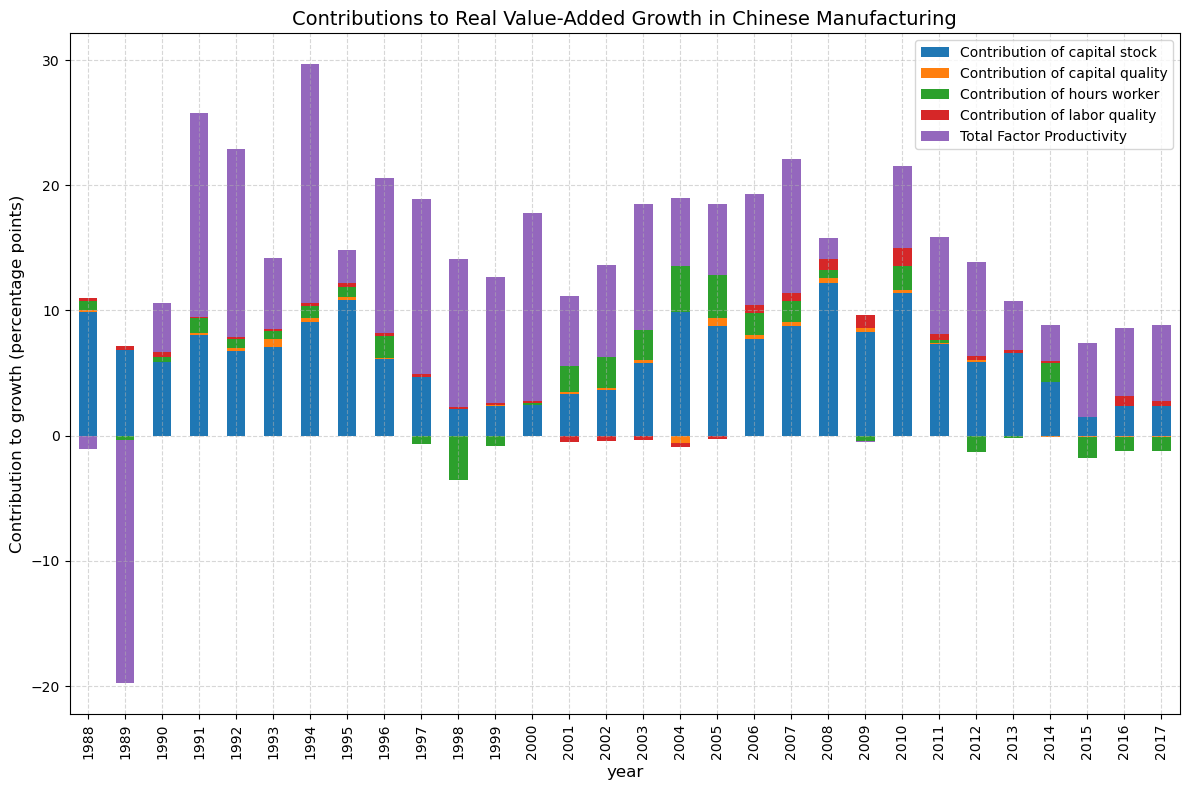

In [17]:
import matplotlib.pyplot as plt

# 重み付き寄与
weight_adjusted_instrument_dict = {
  k: instrument * nominal_va_weight_norm for k, instrument in instrument_dict.items()
}
manufacturing_growth_contributor = pd.DataFrame({ k: instrument.sum(axis=0) * 100 for k, instrument in weight_adjusted_instrument_dict.items()})

manufacturing_growth_contributor.plot(kind="bar", stacked=True, figsize=(12,8))

plt.title("Contributions to Real Value-Added Growth in Chinese Manufacturing", fontsize=14)
plt.xlabel("year", fontsize=12)
plt.ylabel("Contribution to growth (percentage points)", fontsize=12)
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

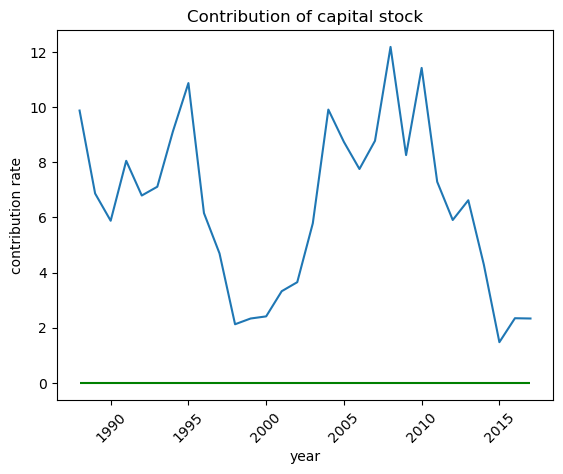

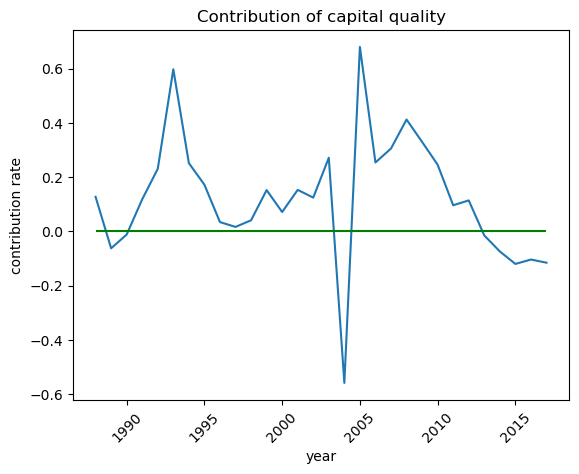

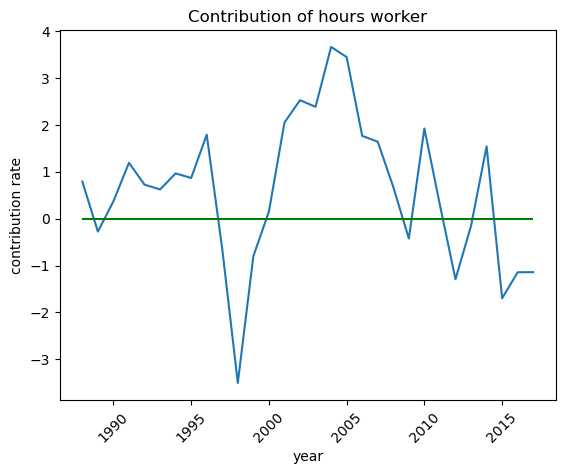

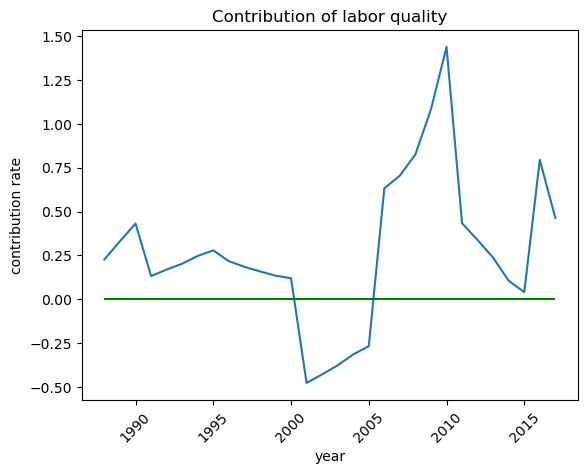

In [18]:
from matplotlib import pyplot as plt
for col in manufacturing_growth_contributor.columns:
  if col.find("Total") != -1:
    continue
  plt.figure()
  plt.plot(manufacturing_growth_contributor[col])
  plt.title(col)
  plt.xlabel("year")
  plt.ylabel("contribution rate")
  plt.xticks(rotation=45)
  plt.hlines(0, manufacturing_growth_contributor[col].index[0], manufacturing_growth_contributor[col].index[-1], color="green")
  plt.show()


In [19]:
from pandas.testing import assert_series_equal

manufacturing_growth_contributor["Sum"] = manufacturing_growth_contributor.sum(axis=1)

growth_rate_float = normalized_data("g(VA)", True)
growth_rate_by_industry = (nominal_va_weight_norm * growth_rate_float) * 100
manufacturing_growth_rate = growth_rate_by_industry.sum()
manufacturing_growth_rate.name = "Sum"

assert_series_equal(manufacturing_growth_rate, manufacturing_growth_contributor["Sum"])


/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/tmp/ipykernel_712/3981646953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decomposed_trend_contributor["Contribution of TFP(Cycle)"] = cycle


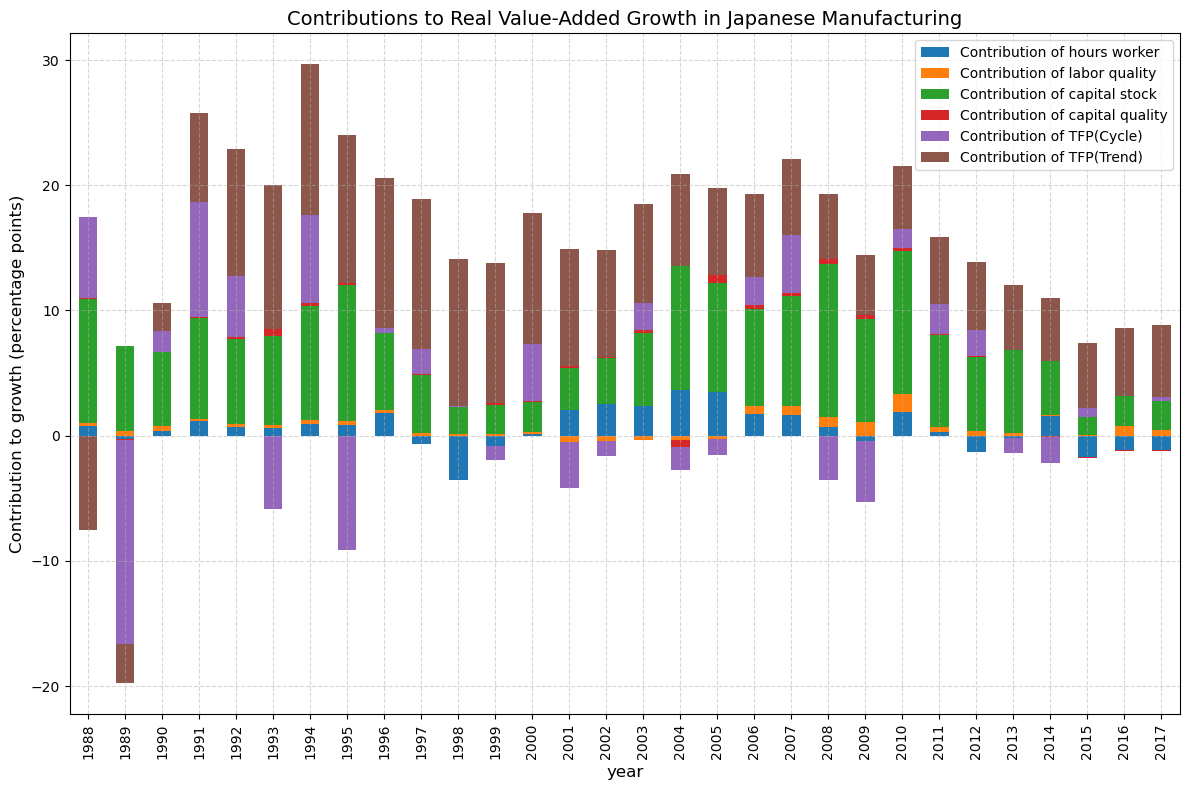

<Axes: title={'center': 'TFP Trend'}, xlabel='year'>

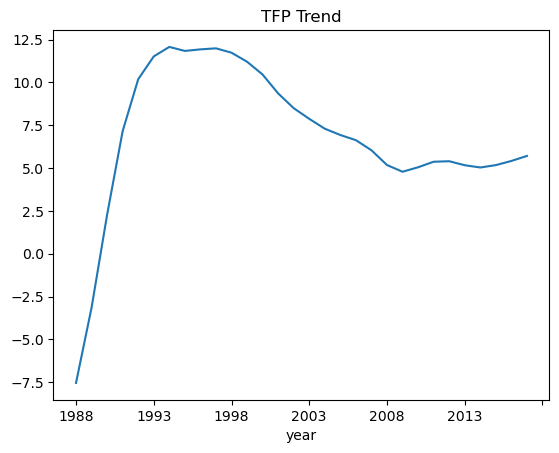

In [20]:
from analysis import utils

cycle, trend = utils.hp_filter_trend(manufacturing_growth_contributor["Total Factor Productivity"], "yearly", True)
decomposed_trend_contributor = manufacturing_growth_contributor[["Contribution of hours worker", "Contribution of labor quality", "Contribution of capital stock", "Contribution of capital quality"]]
decomposed_trend_contributor["Contribution of TFP(Cycle)"] = cycle
decomposed_trend_contributor["Contribution of TFP(Trend)"] = trend
decomposed_trend_contributor.plot(kind="bar", stacked=True, figsize=(12,8))


plt.title("Contributions to Real Value-Added Growth in Japanese Manufacturing", fontsize=14)
plt.xlabel("year", fontsize=12)
plt.ylabel("Contribution to growth (percentage points)", fontsize=12)
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

decomposed_trend_contributor["Contribution of TFP(Trend)"].plot(title="TFP Trend", xlabel="year")


In [21]:
import pandas as pd
from pathlib import Path

# 保存先のパスをPathオブジェクトとして定義
# 現在のディレクトリからの相対パス
output_dir = Path('./analysis/result/ch_manufac') 
output_file = output_dir / 'growth_accounting.csv' # スラッシュでパスを結合できる
output_df = decomposed_trend_contributor.copy()
output_df.insert(0, "year", output_df.index)

# 親フォルダーが存在しない場合は作成する (parents=Trueで階層があってもOK)
output_dir.mkdir(parents=True, exist_ok=True)

# CSVとして保存
output_df.to_csv(output_file, index=False, encoding='utf-8')


# reasoning

- 基本的なデータセット

https://www.rieti.go.jp/en/database/CIP2023/index.html

- 産業コードの整合

Both CSIC and SSIC generally correspond with ISIC, including sector C.

For CSIC
CSIC/2011 は ISIC Rev. 4に基本的にISICに対応している
> The CSIC/2011 is the fifth standards since the first one implemented in 1972 and in principle follows the International Standard Industrial Classification of all economic activities (ISIC) Rev. 4, implemented in 2008 (DESA/SD 2008). 

https://www.rieti.go.jp/jp/publications/dp/15e004.pdf

For SSIC
SSIC 2025 は ISIS Rev.5に対応している
> The Singapore Standard Industrial Classification (SSIC) is the national
standard for classifying economic activities undertaken by economic units. The SSIC is used for censuses of population, business surveys and administrative databases. The SSIC 2025 adopts the basic framework of the latest International Standard Industrial Classification of All Economic Activities Revision 5 (ISIC Rev. 5) developed by the United Nations Statistics Division (UNSD). It is reviewed and updated periodically to reflect developments in the Singapore economy, particularly the emergence of new economic activities as well as to align with changes in the international standard

https://www.singstat.gov.sg/-/media/files/standards_and_classifications/industrial_classification/ssic2025report.ashx
